<a href="https://colab.research.google.com/github/agarr3/vajra-new-2/blob/main/WI_SIMPLE_CNN_CLASSIFIER_MEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

import IPython.display as ipd

import random

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

#settings
batch_size = 128
validation_split = .3
shuffle_dataset = True
random_seed= 42

criterion = nn.CrossEntropyLoss()

n_epochs = 30
print_every = 1




seq_len=200

DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED"
DATA_SONG_DIR = "originals"
DATA_IMG_DIR = "originals"
input_bins = 48
BASE_PATH = "/content/gdrive/My Drive/vajra/WI_CLASSIFIER_V1/ORIGINAL_MEL/"

# DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1"
# DATA_SONG_DIR = "Activations_64"
# DATA_IMG_DIR = "Activations_64"
# input_bins = 64
# BASE_PATH = "/content/gdrive/My Drive/vajra/WI_CLASSIFIER_V1/LAYER1_64/"

# DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1"
# DATA_SONG_DIR = "Activations_128"
# DATA_IMG_DIR = "Activations_128"
# input_bins = 128
# BASE_PATH = "/content/gdrive/My Drive/vajra/WI_CLASSIFIER_V1/LAYER2_128/"

# DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1"
# DATA_SONG_DIR = "reconstructions"
# DATA_IMG_DIR = "reconstructions"
# input_bins = 48
# BASE_PATH = "/content/gdrive/My Drive/vajra/WI_CLASSIFIER_V1/reconstructions/"


TEST_DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED"
TEST_DATA_SONG_DIR = "reconstructions"
TEST_DATA_IMG_DIR = "reconstructions"


TEST_DATA_BASE_PATH_1 = "/content/gdrive/My Drive/vajra/AE_HYBRID_INDIAN"
TEST_DATA_SONG_DIR_1 = "reconstructions"
TEST_DATA_IMG_DIR_1 = "reconstructions"


TEST_DATA_BASE_PATH_2 = "/content/gdrive/My Drive/vajra/AE_HYBRID_WESTERN"
TEST_DATA_SONG_DIR_2 = "reconstructions"
TEST_DATA_IMG_DIR_2 = "reconstructions"


TEST_DATA_BASE_PATH_3 = "/content/gdrive/My Drive/vajra/AE_HYBRID_GTZAN"
TEST_DATA_SONG_DIR_3 = "reconstructions"
TEST_DATA_IMG_DIR_3 = "reconstructions"


TEST_DATA_BASE_PATH_4 = "/content/gdrive/My Drive/vajra/AE_HYBRID_GURBANI"
TEST_DATA_SONG_DIR_4 = "reconstructions"
TEST_DATA_IMG_DIR_4 = "reconstructions"

cuda:0


In [3]:
from google.colab import drive
drive._mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
print(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "Western_numpy"))
             
train_files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "training", "Western_numpy")):
  for file in fileList:
    if(file not in exclusion):
      train_files.append([file,file, "Western_numpy"])
    else:
      print(file)

random.seed(1234)
train_files = random.sample(train_files, len(train_files))

for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "training", "Indian_numpy")):
  for file in fileList:
    if(True):
      train_files.append([file,file, "Indian_numpy"])
    else:
      print(file)

train_data = pd.DataFrame(train_files, columns=['Images','songs','labels'])
train_data.head()

/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/originals/Western_numpy


,Images,songs,labels
0,western_114374_mel_1.npy,western_114374_mel_1.npy,Western_numpy
1,western_148439_mel_0.npy,western_148439_mel_0.npy,Western_numpy
2,western_108531_mel_1.npy,western_108531_mel_1.npy,Western_numpy
3,western_085792_mel_1.npy,western_085792_mel_1.npy,Western_numpy
4,western_134959_mel_0.npy,western_134959_mel_0.npy,Western_numpy


In [5]:
train_data.groupby("labels").count()

,Images,songs
labels,,
Indian_numpy,2811,2811
Western_numpy,2800,2800


In [6]:
test_files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "test", "Western_numpy")):
  for file in fileList:
    if(file not in exclusion):
      test_files.append([file,file, "Western_numpy"])
    else:
      print(file)

random.seed(1234)
test_files = random.sample(test_files, len(test_files))

for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "test", "Indian_numpy")):
  for file in fileList:
    if(True):
      test_files.append([file,file, "Indian_numpy"])
    else:
      print(file)

test_data = pd.DataFrame(test_files, columns=['Images','songs','labels'])
test_data.head()

,Images,songs,labels
0,western_130993_mel_0.npy,western_130993_mel_0.npy,Western_numpy
1,western_120189_mel_1.npy,western_120189_mel_1.npy,Western_numpy
2,western_111579_mel_1.npy,western_111579_mel_1.npy,Western_numpy
3,western_111793_mel_1.npy,western_111793_mel_1.npy,Western_numpy
4,western_122503_mel_1.npy,western_122503_mel_1.npy,Western_numpy


In [7]:
test_data.groupby("labels").count()

,Images,songs
labels,,
Indian_numpy,1205,1205
Western_numpy,1200,1200


/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/originals/training/Western_numpy/western_043621_mel_1.npy
79.96203


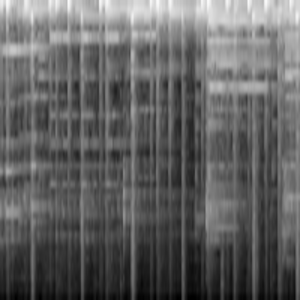

In [8]:
test_idx = random. randint(0,1000)
test_img_path = os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "training", train_data.loc[test_idx, 'labels'], train_data.loc[test_idx, 'Images'])
print(test_img_path)

numpy_arr = np.load(test_img_path)

array = numpy_arr*-1
print(array.max())
array *= (255.0/array.max())
array = 255 - array

test_image = Image.fromarray(array)
test_image = test_image.convert('L')
test_image = test_image.resize((300,300))
test_image



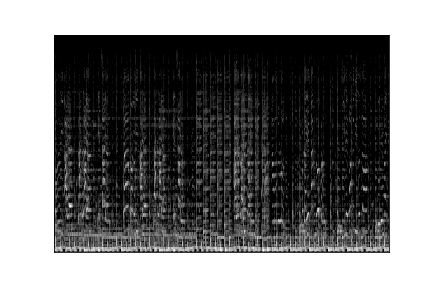

In [9]:
test_img_path = '/content/gdrive/My Drive/Kaggle/GTZAN/Data/images_original/reggae/reggae00016.png'
test_image = Image.open(test_img_path)
test_image = test_image.convert('RGB').convert('L')
test_image

In [10]:
lb = LabelEncoder()
train_data['encoded_labels'] = lb.fit_transform(train_data['labels'])
train_data.head()

,Images,songs,labels,encoded_labels
0,western_114374_mel_1.npy,western_114374_mel_1.npy,Western_numpy,1
1,western_148439_mel_0.npy,western_148439_mel_0.npy,Western_numpy,1
2,western_108531_mel_1.npy,western_108531_mel_1.npy,Western_numpy,1
3,western_085792_mel_1.npy,western_085792_mel_1.npy,Western_numpy,1
4,western_134959_mel_0.npy,western_134959_mel_0.npy,Western_numpy,1


In [11]:
test_data['encoded_labels'] = lb.transform(test_data['labels'])
test_data.head()

,Images,songs,labels,encoded_labels
0,western_130993_mel_0.npy,western_130993_mel_0.npy,Western_numpy,1
1,western_120189_mel_1.npy,western_120189_mel_1.npy,Western_numpy,1
2,western_111579_mel_1.npy,western_111579_mel_1.npy,Western_numpy,1
3,western_111793_mel_1.npy,western_111793_mel_1.npy,Western_numpy,1
4,western_122503_mel_1.npy,western_122503_mel_1.npy,Western_numpy,1


In [12]:
classes = ('Indian_numpy', 'Western_numpy')
train_data.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,2811,2811
Western_numpy,1,2800,2800


In [13]:
test_data.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,1205,1205
Western_numpy,1,1200,1200


In [14]:
from sklearn.model_selection import train_test_split

train_data = train_data.sample(frac=1)
test_data = test_data.sample(frac=1)


#df_train, df_test = train_test_split(data, test_size=validation_split, stratify=data[["labels"]])

df_train = train_data.reset_index(drop=True)
df_test = test_data.reset_index(drop=True)

In [15]:
df_train.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,2811,2811
Western_numpy,1,2800,2800


In [16]:
df_test.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,1205,1205
Western_numpy,1,1200,1200


In [17]:
transform_normal = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.ToTensor()])

In [18]:
class MEL_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = np.load(img_name)
        image = image[:,:seq_len]
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        if self.transform is not None:
            image = self.transform(image)
        fileName = self.img_data.loc[index, 'Images']
        return image, label, fileName



In [19]:
train_dataset = MEL_Dataset(df_train,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "training"),transform)
test_dataset = MEL_Dataset(df_test,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "test"),transform)

In [20]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [21]:
def img_display(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg.squeeze()

def mel_display(S_DB):
    #print(S_DB.shape)
    S_DB = S_DB.numpy()
    array = S_DB*-1
    #print(array.max())
    array *= (255.0/array.max())
    array = 255 - array

    array = np.transpose(array, (1, 2, 0))
    return array.squeeze()

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    array = npimg*-1
    #print(array.max())
    array *= (255.0/array.max())
    array = 255 - array
    array = np.transpose(array, (1, 2, 0))
    plt.imshow(array.squeeze(), interpolation='nearest', aspect='auto')
    plt.show()

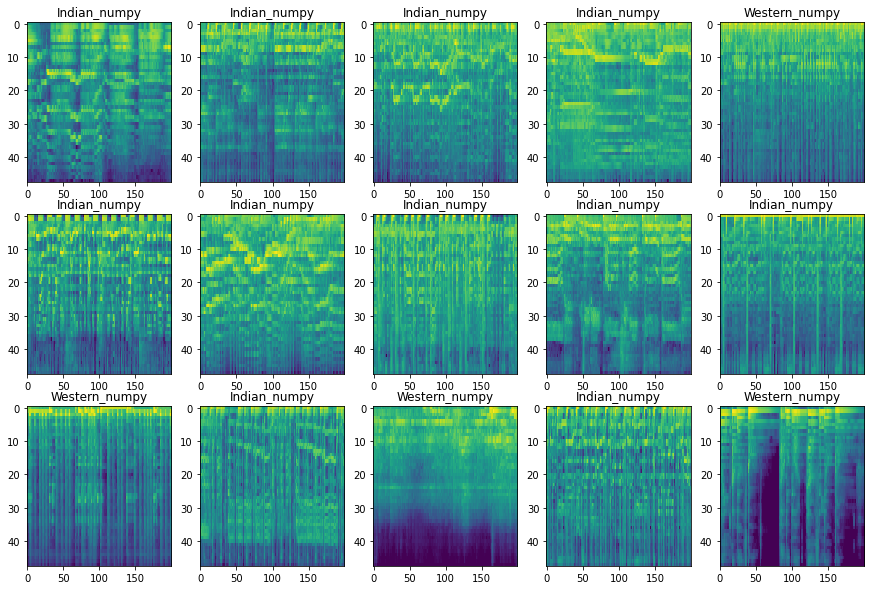

In [22]:
# get some random training images
dataiter = iter(trainloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

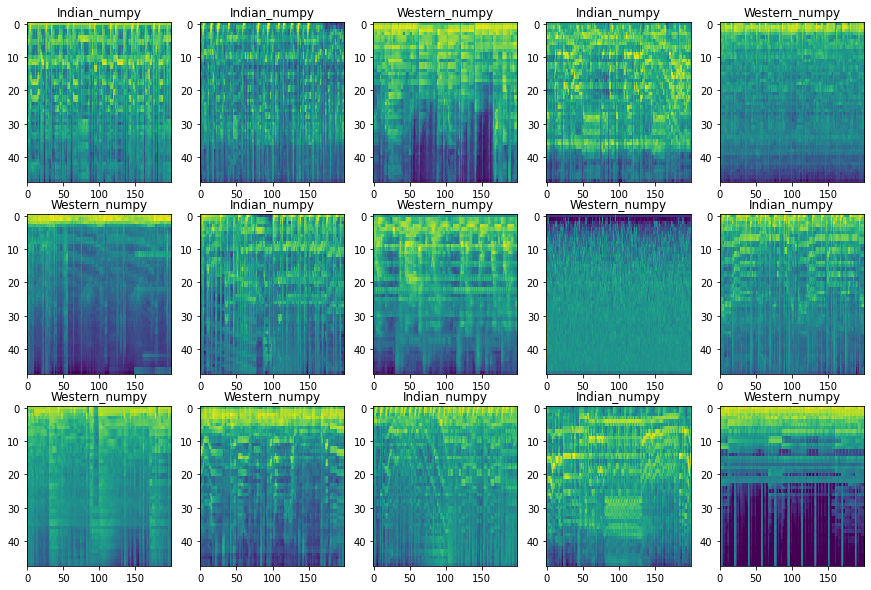

In [23]:
# get some random training images
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [24]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        if input_bins == 48:
          self.fc1 = nn.Linear(6768, 120)
        if input_bins == 64:
          self.fc1 = nn.Linear(9776, 120)
        if input_bins == 128:
          self.fc1 = nn.Linear(21808, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=6768, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [25]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [26]:
best_accuracy = 0.0

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % print_every == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every))
            running_loss = 0.0
    
    print('Accuracy of the network on the train images after epoch {} is {}'.format(epoch, 100 * correct / total) )
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            inputs, labels, fileNames = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy_epoch = 100 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))
    if accuracy_epoch > best_accuracy:
      best_accuracy = accuracy_epoch
      torch.save(net.state_dict(), os.path.join(BASE_PATH, "best_model.pt"))
        
        
    

print('Finished Training')

[1,     1] loss: 0.681
[1,     2] loss: 0.700
[1,     3] loss: 0.677
[1,     4] loss: 0.694
[1,     5] loss: 0.690
[1,     6] loss: 0.689
[1,     7] loss: 0.690
[1,     8] loss: 0.687
[1,     9] loss: 0.702
[1,    10] loss: 0.716
[1,    11] loss: 0.730
[1,    12] loss: 0.769
[1,    13] loss: 0.682
[1,    14] loss: 0.720
[1,    15] loss: 0.721
[1,    16] loss: 0.677
[1,    17] loss: 0.686
[1,    18] loss: 0.684
[1,    19] loss: 0.686
[1,    20] loss: 0.679
[1,    21] loss: 0.706
[1,    22] loss: 0.682
[1,    23] loss: 0.684
[1,    24] loss: 0.682
[1,    25] loss: 0.666
[1,    26] loss: 0.683
[1,    27] loss: 0.709
[1,    28] loss: 0.706
[1,    29] loss: 0.697
[1,    30] loss: 0.682
[1,    31] loss: 0.681
[1,    32] loss: 0.693
[1,    33] loss: 0.697
[1,    34] loss: 0.685
[1,    35] loss: 0.675
[1,    36] loss: 0.687
[1,    37] loss: 0.677
[1,    38] loss: 0.691
[1,    39] loss: 0.675
[1,    40] loss: 0.675
[1,    41] loss: 0.670
[1,    42] loss: 0.674
[1,    43] loss: 0.666
[1,    44] 

In [27]:
model = Net()
model.load_state_dict(torch.load(os.path.join(BASE_PATH, "best_model.pt"), map_location=device))
model.to(device)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=6768, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [28]:
device

device(type='cuda', index=0)

Accuracy for class Indian_numpy is: 76.7 %
Accuracy for class Western_numpy is: 83.5 %


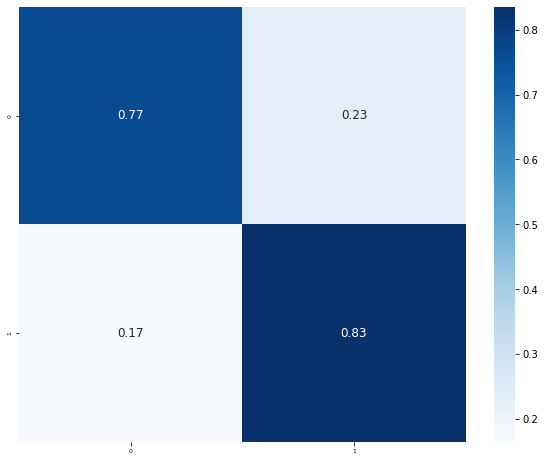

In [29]:
import seaborn as sns
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
num_classes = len(classes)
cm = torch.zeros(num_classes, num_classes)
debugList = []

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        m = nn.Softmax(dim=1)
        probabilities = m(outputs)
        probas, __ = torch.max(probabilities, 1)
        # collect the correct predictions for each class
        for label, prediction, fileName, prob in zip(labels, predictions, fileNames, probas):
            if label == prediction:
                correct_pred[classes[label]] += 1
                debugList.append([fileName, list(lb.inverse_transform([label.item()]))[0], list(lb.inverse_transform([prediction.item()]))[0], 'Correct', prob.item()])
            else:
                debugList.append([fileName, list(lb.inverse_transform([label.item()]))[0], list(lb.inverse_transform([prediction.item()]))[0], 'Not Correct', prob.item()])
            total_pred[classes[label]] += 1
            cm[label, prediction] = cm[label, prediction] + 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))
    
debugDF = pd.DataFrame(debugList, columns=["Song", "Actual category","Precicted", "Preciction", "Preciction Probability"])
debugDF.to_csv(os.path.join(BASE_PATH, "testDebug.csv"))
    
fig = plt.figure(figsize=(10, 8))
confusionMatrix = cm.numpy()
confusionMatrix = confusionMatrix / confusionMatrix.astype(np.float).sum(axis=1, keepdims=True)
hmap = sns.heatmap(confusionMatrix , annot=True,
          fmt='.2', cmap='Blues', annot_kws={"size": 12},xticklabels=[0,1], yticklabels=[0,1])
hmap.set_xticklabels(hmap.get_xmajorticklabels(), fontsize=6)
hmap.set_yticklabels(hmap.get_ymajorticklabels(), fontsize=6)
figure = hmap.get_figure()
plt.show()

Accuracy for class Indian_numpy is: 86.5 %
Accuracy for class Western_numpy is: 89.9 %


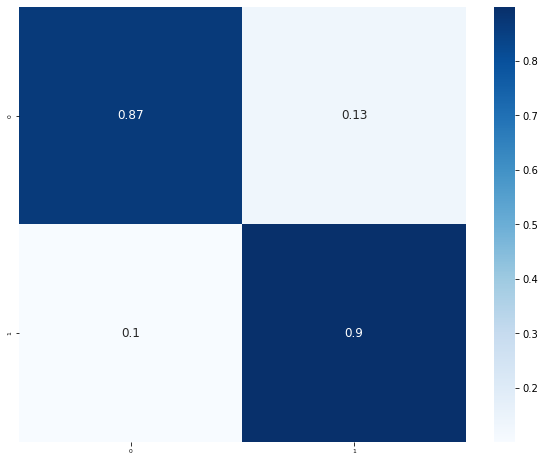

In [30]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
num_classes = len(classes)
cm = torch.zeros(num_classes, num_classes)
debugList = []

# again no gradients needed
with torch.no_grad():
    for data in trainloader:
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        m = nn.Softmax(dim=1)
        probabilities = m(outputs)
        probas, __ = torch.max(probabilities, 1)
        # collect the correct predictions for each class
        for label, prediction, fileName, prob in zip(labels, predictions, fileNames, probas):
            if label == prediction:
                correct_pred[classes[label]] += 1
                debugList.append([fileName, list(lb.inverse_transform([label.item()]))[0], list(lb.inverse_transform([prediction.item()]))[0], 'Correct', prob.item()])
            else:
                debugList.append([fileName, list(lb.inverse_transform([label.item()]))[0], list(lb.inverse_transform([prediction.item()]))[0], 'Not Correct', prob.item()])
            total_pred[classes[label]] += 1
            cm[label, prediction] = cm[label, prediction] + 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))
    
debugDF = pd.DataFrame(debugList, columns=["Song", "Actual category","Precicted", "Preciction", "Preciction Probability"])
debugDF.to_csv(os.path.join(BASE_PATH, "trainDebug.csv"))
    
fig = plt.figure(figsize=(10, 8))
confusionMatrix = cm.numpy()
confusionMatrix = confusionMatrix / confusionMatrix.astype(np.float).sum(axis=1, keepdims=True)
hmap = sns.heatmap(confusionMatrix , annot=True,
          fmt='.2', cmap='Blues', annot_kws={"size": 12},xticklabels=[0,1], yticklabels=[0,1])
hmap.set_xticklabels(hmap.get_xmajorticklabels(), fontsize=6)
hmap.set_yticklabels(hmap.get_ymajorticklabels(), fontsize=6)
figure = hmap.get_figure()
plt.show()

In [31]:
classes

('Indian_numpy', 'Western_numpy')

Cross validation code start

In [32]:
files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
print(os.path.join(TEST_DATA_BASE_PATH, TEST_DATA_IMG_DIR, "test", "Western_numpy"))
for r,d, fileList in os.walk(os.path.join(TEST_DATA_BASE_PATH, TEST_DATA_IMG_DIR, "test", "Western_numpy")):
  for file in fileList:
    if(file not in exclusion):
      files.append([file,file, "Western_numpy"])
    else:
      print(file)

# random.seed(1234)
# files = random.sample(files, 2008)

for r,d, fileList in os.walk(os.path.join(TEST_DATA_BASE_PATH, TEST_DATA_IMG_DIR, "test","Indian_numpy")):
  for file in fileList:
    if(True):
      files.append([file,file, "Indian_numpy"])
    else:
      print(file)

data = pd.DataFrame(files, columns=['Images','songs','labels'])
data.head()

/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/reconstructions/test/Western_numpy


,Images,songs,labels
0,western_080835_mel_0.npy,western_080835_mel_0.npy,Western_numpy
1,western_155066_mel_1.npy,western_155066_mel_1.npy,Western_numpy
2,western_115597_mel_0.npy,western_115597_mel_0.npy,Western_numpy
3,western_099389_mel_0.npy,western_099389_mel_0.npy,Western_numpy
4,western_093364_mel_1.npy,western_093364_mel_1.npy,Western_numpy


In [33]:
data['encoded_labels'] = lb.transform(data['labels'])
data.head()

,Images,songs,labels,encoded_labels
0,western_080835_mel_0.npy,western_080835_mel_0.npy,Western_numpy,1
1,western_155066_mel_1.npy,western_155066_mel_1.npy,Western_numpy,1
2,western_115597_mel_0.npy,western_115597_mel_0.npy,Western_numpy,1
3,western_099389_mel_0.npy,western_099389_mel_0.npy,Western_numpy,1
4,western_093364_mel_1.npy,western_093364_mel_1.npy,Western_numpy,1


In [34]:
cross_dataset = MEL_Dataset(data,os.path.join(TEST_DATA_BASE_PATH, TEST_DATA_IMG_DIR, "test"),transform)
crossloader = torch.utils.data.DataLoader(cross_dataset, batch_size=batch_size)

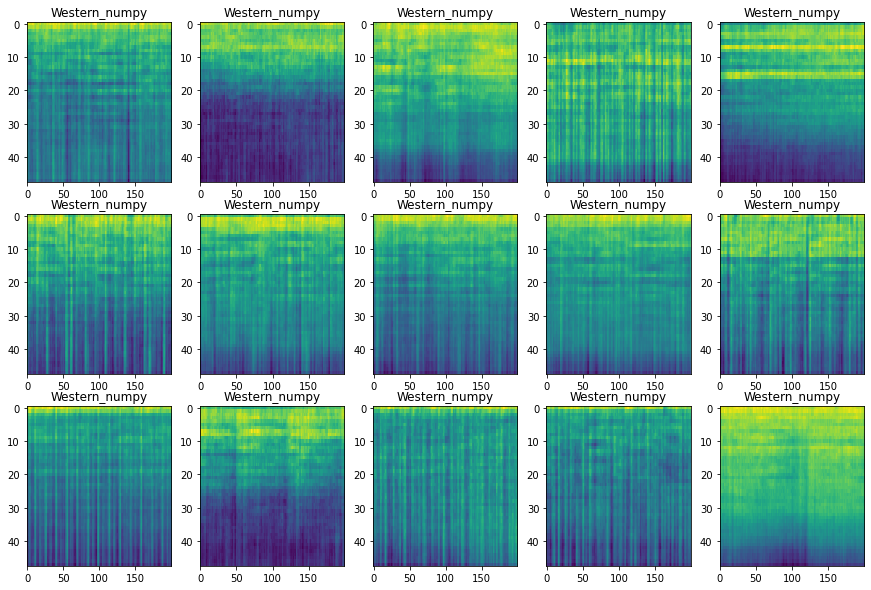

In [35]:
# get some random training images
dataiter = iter(crossloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

Accuracy for class Indian_numpy is: 12.7 %
Accuracy for class Western_numpy is: 98.2 %


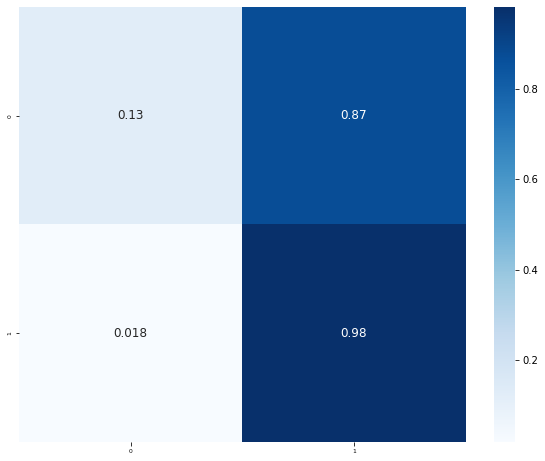

In [36]:
import seaborn as sns
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
num_classes = len(classes)
cm = torch.zeros(num_classes, num_classes)
debugList = []

# again no gradients needed
with torch.no_grad():
    for data in crossloader:
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        m = nn.Softmax(dim=1)
        probabilities = m(outputs)
        probas, __ = torch.max(probabilities, 1)
        # collect the correct predictions for each class
        for label, prediction, fileName, prob in zip(labels, predictions, fileNames, probas):
            if label == prediction:
                correct_pred[classes[label]] += 1
                debugList.append([fileName, list(lb.inverse_transform([label.item()]))[0], list(lb.inverse_transform([prediction.item()]))[0], 'Correct', prob.item()])
            else:
                debugList.append([fileName, list(lb.inverse_transform([label.item()]))[0], list(lb.inverse_transform([prediction.item()]))[0], 'Not Correct', prob.item()])
            total_pred[classes[label]] += 1
            cm[label, prediction] = cm[label, prediction] + 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))
    
debugDF = pd.DataFrame(debugList, columns=["Song", "Actual category","Precicted", "Preciction", "Preciction Probability"])
debugDF.to_csv(os.path.join(BASE_PATH, "crossTestDebug.csv"))

fig = plt.figure(figsize=(10, 8))
confusionMatrix = cm.numpy()
confusionMatrix = confusionMatrix / confusionMatrix.astype(np.float).sum(axis=1, keepdims=True)
hmap = sns.heatmap(confusionMatrix , annot=True,
          fmt='.2', cmap='Blues', annot_kws={"size": 12},xticklabels=[0,1], yticklabels=[0,1])
hmap.set_xticklabels(hmap.get_xmajorticklabels(), fontsize=6)
hmap.set_yticklabels(hmap.get_ymajorticklabels(), fontsize=6)
figure = hmap.get_figure()
plt.show()

In [37]:
files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
print(os.path.join(TEST_DATA_BASE_PATH_1, TEST_DATA_IMG_DIR_1, "test", "Western_numpy"))
for r,d, fileList in os.walk(os.path.join(TEST_DATA_BASE_PATH_1, TEST_DATA_IMG_DIR_1, "test", "Western_numpy")):
  for file in fileList:
    if(file not in exclusion):
      files.append([file,file, "Western_numpy"])
    else:
      print(file)

# random.seed(1234)
# files = random.sample(files, 2008)

for r,d, fileList in os.walk(os.path.join(TEST_DATA_BASE_PATH_1, TEST_DATA_IMG_DIR_1, "test","Indian_numpy")):
  for file in fileList:
    if(True):
      files.append([file,file, "Indian_numpy"])
    else:
      print(file)

data = pd.DataFrame(files, columns=['Images','songs','labels'])
data.head()

/content/gdrive/My Drive/vajra/AE_HYBRID_INDIAN/reconstructions/test/Western_numpy


,Images,songs,labels
0,western_089815_mel_1.npy,western_089815_mel_1.npy,Western_numpy
1,western_125722_mel_0.npy,western_125722_mel_0.npy,Western_numpy
2,western_075745_mel_0.npy,western_075745_mel_0.npy,Western_numpy
3,western_145553_mel_1.npy,western_145553_mel_1.npy,Western_numpy
4,western_027981_mel_1.npy,western_027981_mel_1.npy,Western_numpy


In [38]:
data['encoded_labels'] = lb.transform(data['labels'])
data.head()

,Images,songs,labels,encoded_labels
0,western_089815_mel_1.npy,western_089815_mel_1.npy,Western_numpy,1
1,western_125722_mel_0.npy,western_125722_mel_0.npy,Western_numpy,1
2,western_075745_mel_0.npy,western_075745_mel_0.npy,Western_numpy,1
3,western_145553_mel_1.npy,western_145553_mel_1.npy,Western_numpy,1
4,western_027981_mel_1.npy,western_027981_mel_1.npy,Western_numpy,1


In [39]:
cross_dataset = MEL_Dataset(data,os.path.join(TEST_DATA_BASE_PATH_1, TEST_DATA_IMG_DIR_1, "test"),transform)
crossloader = torch.utils.data.DataLoader(cross_dataset, batch_size=batch_size)

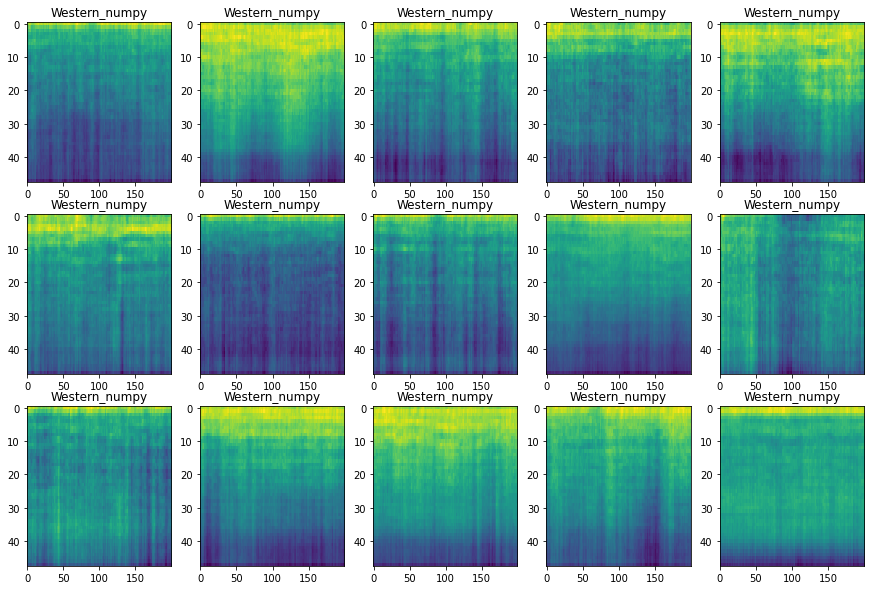

In [40]:
# get some random training images
dataiter = iter(crossloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [ ]:
import seaborn as sns
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
num_classes = len(classes)
cm = torch.zeros(num_classes, num_classes)
debugList = []

# again no gradients needed
with torch.no_grad():
    for data in crossloader:
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        m = nn.Softmax(dim=1)
        probabilities = m(outputs)
        probas, __ = torch.max(probabilities, 1)
        # collect the correct predictions for each class
        for label, prediction, fileName, prob in zip(labels, predictions, fileNames, probas):
            if label == prediction:
                correct_pred[classes[label]] += 1
                debugList.append([fileName, list(lb.inverse_transform([label.item()]))[0], list(lb.inverse_transform([prediction.item()]))[0], 'Correct', prob.item()])
            else:
                debugList.append([fileName, list(lb.inverse_transform([label.item()]))[0], list(lb.inverse_transform([prediction.item()]))[0], 'Not Correct', prob.item()])
            total_pred[classes[label]] += 1
            cm[label, prediction] = cm[label, prediction] + 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))
    
debugDF = pd.DataFrame(debugList, columns=["Song", "Actual category","Precicted", "Preciction", "Preciction Probability"])
debugDF.to_csv(os.path.join(BASE_PATH, "crossTestDebug.csv"))

fig = plt.figure(figsize=(10, 8))
confusionMatrix = cm.numpy()
confusionMatrix = confusionMatrix / confusionMatrix.astype(np.float).sum(axis=1, keepdims=True)
hmap = sns.heatmap(confusionMatrix , annot=True,
          fmt='.2', cmap='Blues', annot_kws={"size": 12},xticklabels=[0,1], yticklabels=[0,1])
hmap.set_xticklabels(hmap.get_xmajorticklabels(), fontsize=6)
hmap.set_yticklabels(hmap.get_ymajorticklabels(), fontsize=6)
figure = hmap.get_figure()
plt.show()

In [ ]:
files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
print(os.path.join(TEST_DATA_BASE_PATH_2, TEST_DATA_IMG_DIR_2, "test", "Western_numpy"))
for r,d, fileList in os.walk(os.path.join(TEST_DATA_BASE_PATH_2, TEST_DATA_IMG_DIR_2, "test", "Western_numpy")):
  for file in fileList:
    if(file not in exclusion):
      files.append([file,file, "Western_numpy"])
    else:
      print(file)

# random.seed(1234)
# files = random.sample(files, 2008)

for r,d, fileList in os.walk(os.path.join(TEST_DATA_BASE_PATH_2, TEST_DATA_IMG_DIR_2, "test","Indian_numpy")):
  for file in fileList:
    if(True):
      files.append([file,file, "Indian_numpy"])
    else:
      print(file)

data = pd.DataFrame(files, columns=['Images','songs','labels'])
data.head()

In [ ]:
data['encoded_labels'] = lb.transform(data['labels'])
data.head()

In [ ]:
cross_dataset = MEL_Dataset(data,os.path.join(TEST_DATA_BASE_PATH_2, TEST_DATA_IMG_DIR_2, "test"),transform)
crossloader = torch.utils.data.DataLoader(cross_dataset, batch_size=batch_size)

In [ ]:
# get some random training images
dataiter = iter(crossloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [ ]:
import seaborn as sns
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
num_classes = len(classes)
cm = torch.zeros(num_classes, num_classes)
debugList = []

# again no gradients needed
with torch.no_grad():
    for data in crossloader:
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        m = nn.Softmax(dim=1)
        probabilities = m(outputs)
        probas, __ = torch.max(probabilities, 1)
        # collect the correct predictions for each class
        for label, prediction, fileName, prob in zip(labels, predictions, fileNames, probas):
            if label == prediction:
                correct_pred[classes[label]] += 1
                debugList.append([fileName, list(lb.inverse_transform([label.item()]))[0], list(lb.inverse_transform([prediction.item()]))[0], 'Correct', prob.item()])
            else:
                debugList.append([fileName, list(lb.inverse_transform([label.item()]))[0], list(lb.inverse_transform([prediction.item()]))[0], 'Not Correct', prob.item()])
            total_pred[classes[label]] += 1
            cm[label, prediction] = cm[label, prediction] + 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))
    
debugDF = pd.DataFrame(debugList, columns=["Song", "Actual category","Precicted", "Preciction", "Preciction Probability"])
debugDF.to_csv(os.path.join(BASE_PATH, "crossTestDebug.csv"))

fig = plt.figure(figsize=(10, 8))
confusionMatrix = cm.numpy()
confusionMatrix = confusionMatrix / confusionMatrix.astype(np.float).sum(axis=1, keepdims=True)
hmap = sns.heatmap(confusionMatrix , annot=True,
          fmt='.2', cmap='Blues', annot_kws={"size": 12},xticklabels=[0,1], yticklabels=[0,1])
hmap.set_xticklabels(hmap.get_xmajorticklabels(), fontsize=6)
hmap.set_yticklabels(hmap.get_ymajorticklabels(), fontsize=6)
figure = hmap.get_figure()
plt.show()

In [ ]:
files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
print(os.path.join(TEST_DATA_BASE_PATH_3, TEST_DATA_IMG_DIR_3, "test", "Western_numpy"))
for r,d, fileList in os.walk(os.path.join(TEST_DATA_BASE_PATH_3, TEST_DATA_IMG_DIR_3, "test", "Western_numpy")):
  for file in fileList:
    if(file not in exclusion):
      files.append([file,file, "Western_numpy"])
    else:
      print(file)

# random.seed(1234)
# files = random.sample(files, 2008)

for r,d, fileList in os.walk(os.path.join(TEST_DATA_BASE_PATH_3, TEST_DATA_IMG_DIR_3, "test","Indian_numpy")):
  for file in fileList:
    if(True):
      files.append([file,file, "Indian_numpy"])
    else:
      print(file)

data = pd.DataFrame(files, columns=['Images','songs','labels'])
data.head()

In [ ]:
data['encoded_labels'] = lb.transform(data['labels'])
data.head()

In [ ]:
cross_dataset = MEL_Dataset(data,os.path.join(TEST_DATA_BASE_PATH_3, TEST_DATA_IMG_DIR_3, "test"),transform)
crossloader = torch.utils.data.DataLoader(cross_dataset, batch_size=batch_size)

In [ ]:
# get some random training images
dataiter = iter(crossloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [ ]:
import seaborn as sns
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
num_classes = len(classes)
cm = torch.zeros(num_classes, num_classes)
debugList = []

# again no gradients needed
with torch.no_grad():
    for data in crossloader:
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        m = nn.Softmax(dim=1)
        probabilities = m(outputs)
        probas, __ = torch.max(probabilities, 1)
        # collect the correct predictions for each class
        for label, prediction, fileName, prob in zip(labels, predictions, fileNames, probas):
            if label == prediction:
                correct_pred[classes[label]] += 1
                debugList.append([fileName, list(lb.inverse_transform([label.item()]))[0], list(lb.inverse_transform([prediction.item()]))[0], 'Correct', prob.item()])
            else:
                debugList.append([fileName, list(lb.inverse_transform([label.item()]))[0], list(lb.inverse_transform([prediction.item()]))[0], 'Not Correct', prob.item()])
            total_pred[classes[label]] += 1
            cm[label, prediction] = cm[label, prediction] + 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))
    
debugDF = pd.DataFrame(debugList, columns=["Song", "Actual category","Precicted", "Preciction", "Preciction Probability"])
debugDF.to_csv(os.path.join(BASE_PATH, "crossTestDebug.csv"))

fig = plt.figure(figsize=(10, 8))
confusionMatrix = cm.numpy()
confusionMatrix = confusionMatrix / confusionMatrix.astype(np.float).sum(axis=1, keepdims=True)
hmap = sns.heatmap(confusionMatrix , annot=True,
          fmt='.2', cmap='Blues', annot_kws={"size": 12},xticklabels=[0,1], yticklabels=[0,1])
hmap.set_xticklabels(hmap.get_xmajorticklabels(), fontsize=6)
hmap.set_yticklabels(hmap.get_ymajorticklabels(), fontsize=6)
figure = hmap.get_figure()
plt.show()

In [ ]:
files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
print(os.path.join(TEST_DATA_BASE_PATH_4, TEST_DATA_IMG_DIR_4, "test", "Western_numpy"))
for r,d, fileList in os.walk(os.path.join(TEST_DATA_BASE_PATH_4, TEST_DATA_IMG_DIR_4, "test", "Western_numpy")):
  for file in fileList:
    if(file not in exclusion):
      files.append([file,file, "Western_numpy"])
    else:
      print(file)

# random.seed(1234)
# files = random.sample(files, 2008)

for r,d, fileList in os.walk(os.path.join(TEST_DATA_BASE_PATH_4, TEST_DATA_IMG_DIR_4, "test","Indian_numpy")):
  for file in fileList:
    if(True):
      files.append([file,file, "Indian_numpy"])
    else:
      print(file)

data = pd.DataFrame(files, columns=['Images','songs','labels'])
data.head()

In [ ]:
data['encoded_labels'] = lb.transform(data['labels'])
data.head()

In [ ]:
cross_dataset = MEL_Dataset(data,os.path.join(TEST_DATA_BASE_PATH_4, TEST_DATA_IMG_DIR_4, "test"),transform)
crossloader = torch.utils.data.DataLoader(cross_dataset, batch_size=batch_size)

In [ ]:
# get some random training images
dataiter = iter(crossloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [ ]:
import seaborn as sns
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
num_classes = len(classes)
cm = torch.zeros(num_classes, num_classes)
debugList = []

# again no gradients needed
with torch.no_grad():
    for data in crossloader:
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        m = nn.Softmax(dim=1)
        probabilities = m(outputs)
        probas, __ = torch.max(probabilities, 1)
        # collect the correct predictions for each class
        for label, prediction, fileName, prob in zip(labels, predictions, fileNames, probas):
            if label == prediction:
                correct_pred[classes[label]] += 1
                debugList.append([fileName, list(lb.inverse_transform([label.item()]))[0], list(lb.inverse_transform([prediction.item()]))[0], 'Correct', prob.item()])
            else:
                debugList.append([fileName, list(lb.inverse_transform([label.item()]))[0], list(lb.inverse_transform([prediction.item()]))[0], 'Not Correct', prob.item()])
            total_pred[classes[label]] += 1
            cm[label, prediction] = cm[label, prediction] + 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))
    
debugDF = pd.DataFrame(debugList, columns=["Song", "Actual category","Precicted", "Preciction", "Preciction Probability"])
debugDF.to_csv(os.path.join(BASE_PATH, "crossTestDebug.csv"))

fig = plt.figure(figsize=(10, 8))
confusionMatrix = cm.numpy()
confusionMatrix = confusionMatrix / confusionMatrix.astype(np.float).sum(axis=1, keepdims=True)
hmap = sns.heatmap(confusionMatrix , annot=True,
          fmt='.2', cmap='Blues', annot_kws={"size": 12},xticklabels=[0,1], yticklabels=[0,1])
hmap.set_xticklabels(hmap.get_xmajorticklabels(), fontsize=6)
hmap.set_yticklabels(hmap.get_ymajorticklabels(), fontsize=6)
figure = hmap.get_figure()
plt.show()